In [5]:
import os
import matplotlib.pyplot as plt
import cv2
from tqdm import tqdm
from skimage.color import rgb2gray
from scipy import ndimage
%matplotlib inline

import pandas as pd
import numpy as np
import pickle
from PIL import Image
import random
from keras.applications.resnet50 import ResNet50

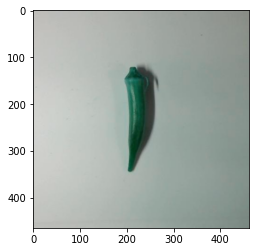

In [6]:

DATADIR = "/content/drive/My Drive/okra_image"

CATEGORIES = ["August_RGB_A", "August_RGB_A"]

for category in CATEGORIES:  
    path = os.path.join(DATADIR,category) 
    for img in os.listdir(path):
        image = cv2.imread(os.path.join(path,img) )  
        image.shape 
        plt.imshow(image)

        break  
    break  

In [8]:
IMG_LONG = 224
IMG_LARGE = 224
training_data = []

def create_training_data():
    for category in CATEGORIES:

        path = os.path.join(DATADIR,category)  
        class_num = CATEGORIES.index(category)  

        for img in tqdm(os.listdir(path)):   
            try:
                image = cv2.imread(os.path.join(path,img))                
                new_array = image
                new_array = cv2.resize(new_array,(IMG_LARGE, IMG_LONG))
                training_data.append([new_array, class_num])
            except Exception as e:  # in the interest in keeping the output clean...
                pass
            
            
            
create_training_data()
print("")
print(len(training_data))

100%|██████████| 252/252 [00:01<00:00, 219.63it/s]


504


In [10]:
random.shuffle(training_data)

X = []
y = []

for features,label in training_data:
    X.append(features)
    y.append(label)

y = np.array(y)
X = np.array(X).reshape(-1, IMG_LONG, IMG_LARGE, 3)


In [11]:
%tensorflow_version 1.x
import tensorflow.keras as K

input_t = K.Input(shape=(224,224,3))
res_model = K.applications.ResNet50(include_top =False,
                                    weights="imagenet",
                                    input_tensor = input_t)



TensorFlow is already loaded. Please restart the runtime to change versions.
94773248/94765736 [==============================] - 1s 0us/step


In [15]:
for layer in res_model.layers[:143]:
        layer.trainable = False
# Check the freezed was done ok
for i, layer in enumerate(res_model.layers):
    print(i, layer.name, "-", layer.trainable)


0 input_1 - False
1 conv1_pad - False
2 conv1_conv - False
3 conv1_bn - False
4 conv1_relu - False
5 pool1_pad - False
6 pool1_pool - False
7 conv2_block1_1_conv - False
8 conv2_block1_1_bn - False
9 conv2_block1_1_relu - False
10 conv2_block1_2_conv - False
11 conv2_block1_2_bn - False
12 conv2_block1_2_relu - False
13 conv2_block1_0_conv - False
14 conv2_block1_3_conv - False
15 conv2_block1_0_bn - False
16 conv2_block1_3_bn - False
17 conv2_block1_add - False
18 conv2_block1_out - False
19 conv2_block2_1_conv - False
20 conv2_block2_1_bn - False
21 conv2_block2_1_relu - False
22 conv2_block2_2_conv - False
23 conv2_block2_2_bn - False
24 conv2_block2_2_relu - False
25 conv2_block2_3_conv - False
26 conv2_block2_3_bn - False
27 conv2_block2_add - False
28 conv2_block2_out - False
29 conv2_block3_1_conv - False
30 conv2_block3_1_bn - False
31 conv2_block3_1_relu - False
32 conv2_block3_2_conv - False
33 conv2_block3_2_bn - False
34 conv2_block3_2_relu - False
35 conv2_block3_3_conv - 

In [13]:
with tf.device('/gpu:0'):
    to_res = (224, 224)

    model = K.models.Sequential()
    model.add(res_model)

    
    model.add(K.layers.Flatten())
    #model.add(K.layers.Dense(64, activation='relu'))
    model.add(K.layers.BatchNormalization())
    model.add(K.layers.Dense(256, activation='relu'))
    model.add(K.layers.Dropout(0.5))
    model.add(K.layers.BatchNormalization())
    model.add(K.layers.Dense(128, activation='relu'))
    model.add(K.layers.Dropout(0.5))
    model.add(K.layers.BatchNormalization())
    model.add(K.layers.Dense(64, activation='relu'))
    model.add(K.layers.Dropout(0.5))
    model.add(K.layers.BatchNormalization())
    model.add(K.layers.Dense(1, activation='sigmoid'))
    
    model.compile(loss='categorical_crossentropy',
                optimizer = "adam",
                metrics=['accuracy'])
    history = model.fit(X, y, batch_size=32, epochs=5 
                        , validation_split=0.2)
                        #validation_data= (X_test, y_test))#,
                        #callbacks=[check_point])

    #model.summary()

Epoch 1/5
13/13 [==============================] - 14s 298ms/step - loss: 0.0000e+00 - accuracy: 0.4701 - val_loss: 0.0000e+00 - val_accuracy: 0.4752
Epoch 2/5
13/13 [==============================] - 2s 157ms/step - loss: 0.0000e+00 - accuracy: 0.5721 - val_loss: 0.0000e+00 - val_accuracy: 0.4851
Epoch 3/5
13/13 [==============================] - 2s 157ms/step - loss: 0.0000e+00 - accuracy: 0.6061 - val_loss: 0.0000e+00 - val_accuracy: 0.5743
Epoch 4/5
13/13 [==============================] - 2s 158ms/step - loss: 0.0000e+00 - accuracy: 0.6488 - val_loss: 0.0000e+00 - val_accuracy: 0.8614
Epoch 5/5
13/13 [==============================] - 2s 159ms/step - loss: 0.0000e+00 - accuracy: 0.6485 - val_loss: 0.0000e+00 - val_accuracy: 0.9703


In [14]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 7, 7, 2048)        23587712  
_________________________________________________________________
flatten (Flatten)            (None, 100352)            0         
_________________________________________________________________
batch_normalization (BatchNo (None, 100352)            401408    
_________________________________________________________________
dense (Dense)                (None, 256)               25690368  
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 256)               1024      
_________________________________________________________________
dense_1 (Dense)              (None, 128)               3